# Imports:

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### Read in the data:

In [2]:
combo = pd.read_csv('../data/combo.csv')
combo.head()

,created_utc,title,self_text,subreddit
0,1.697477e+09,Most absurd thing a parent has complained about?,I was just thinking about this so I'll go firs...,teaching
1,1.697558e+09,How do you differentiate for students that can...,"For context, I’m a 5th grade ELA teacher. I ha...",teaching
2,1.697568e+09,How to ask a teacher if I can observe their cl...,Hi yall !! I'm in a 5 year BEd program where w...,teaching
3,1.697489e+09,My TA is constantly being taken to support oth...,I guess I just want to see what other schools ...,teaching
4,1.697502e+09,Dropped out of college trying to be a teacher,TLDR:Dropped out but plan to return eventually...,teaching


In [3]:
combo['subreddit'].value_counts(normalize=True)

mentalhealth    0.571385
teaching        0.428615
Name: subreddit, dtype: float64

_Almost a 50/50 split_

**Binarize subreddit column:**


teaching -> 0

mentalhealth --> 1

In [4]:
combo['subreddit'] = combo['subreddit'].map({'teaching': 0, 'mentalhealth': 1})
combo.tail()

,created_utc,title,self_text,subreddit
3308,1.644075e+09,Crying on my birthday,It’s my birthday today and I’m sat here ballin...,1
3309,1.656595e+09,“Happiness is a Choice” - do we all agree this...,"I heard my sister, someone who has chronic anx...",1
3310,1.633300e+09,We. Can't. Diagnose. Anybody.,"Not you, not your parents, not some kid you kn...",1
3311,1.632927e+09,My Dad Committed Suicide Two Days After My Bir...,I am a 36(M). My father committed suicide two ...,1
3312,1.609169e+09,Thank you Reddit from a mental health patient,Just wanted to express gratitude to nobody in ...,1


In [5]:
combo.head()

,created_utc,title,self_text,subreddit
0,1.697477e+09,Most absurd thing a parent has complained about?,I was just thinking about this so I'll go firs...,0
1,1.697558e+09,How do you differentiate for students that can...,"For context, I’m a 5th grade ELA teacher. I ha...",0
2,1.697568e+09,How to ask a teacher if I can observe their cl...,Hi yall !! I'm in a 5 year BEd program where w...,0
3,1.697489e+09,My TA is constantly being taken to support oth...,I guess I just want to see what other schools ...,0
4,1.697502e+09,Dropped out of college trying to be a teacher,TLDR:Dropped out but plan to return eventually...,0


In [6]:
combo['subreddit'].value_counts()

1    1893
0    1420
Name: subreddit, dtype: int64

# Titles only

### Model 1: Using CV & MultinomialNB

In [7]:
X = combo['title']
y = combo['subreddit']

_Baseline:_

In [8]:
1 - y.mean()

0.42861454874735894

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [10]:
X_train.shape

(2484,)

In [11]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [12]:
pipe.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'nb': MultinomialNB(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True,
 'nb__force_alpha': 'warn'}

In [13]:
pipe_params = {
    'cvec__max_features': [500, 1_000, 2_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1, 1), (2, 2)],
    'cvec__stop_words': [None, 'english'],
    
}

In [14]:
gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 5)

In [15]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [500, 1000, 2000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (2, 2)],
                         'cvec__stop_words': [None, 'english']})

In [16]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 2000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english'}

In [17]:
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

0.9206924315619968
0.8721351025331725


### Model 2: Using CV & LogRegression

In [18]:
X = combo['title']
y = combo['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1002)

In [19]:
1 - y_train.mean()

0.43599033816425126

In [20]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

In [21]:
pipe.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('lr', LogisticRegression())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'lr': LogisticRegression(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 100,
 'lr__multi_class': 'auto',
 'lr__n_jobs': None,
 'lr__penalty': 'l2',
 'lr__random_state': None,
 'lr__solver': 'lbfgs',
 'lr__tol': 0.0001,
 'lr__verbose': 0,
 'lr__warm_start': False}

In [22]:
# pipe_params = {
#     'cvec__max_features': [1_000, 2_000, 3_000],
#     'cvec__min_df': [2, 3],
#     'cvec__max_df': [.9, .95],
#     'cvec__ngram_range': [(1, 1), (2, 2)],
#     'cvec__stop_words': [None, 'english'],
#     'lr__C': [0.5, 1]
# }

In [23]:
pipe_params = {
    'cvec__max_features': [1_000, 2_000, 3_000],
    'cvec__ngram_range': [(1, 1), (2, 2)],
    'cvec__stop_words': [None, 'english'],
    'lr__C': [0.5, 1, 2, 3]
}

In [24]:
gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 5)

In [25]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_features': [1000, 2000, 3000],
                         'cvec__ngram_range': [(1, 1), (2, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'lr__C': [0.5, 1, 2, 3]})

In [26]:
print(gs.best_params_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

{'cvec__max_features': 3000, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'lr__C': 3}
0.9766505636070854
0.8661037394451147


### Model 3: Using Tfid & NB

In [27]:
X = combo['title']
y = combo['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1002)

In [28]:
1 - y_train.mean()

0.43599033816425126

In [29]:
pipe = Pipeline([
    ('tf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [30]:
pipe.get_params()

{'memory': None,
 'steps': [('tf', TfidfVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'tf': TfidfVectorizer(),
 'nb': MultinomialNB(),
 'tf__analyzer': 'word',
 'tf__binary': False,
 'tf__decode_error': 'strict',
 'tf__dtype': numpy.float64,
 'tf__encoding': 'utf-8',
 'tf__input': 'content',
 'tf__lowercase': True,
 'tf__max_df': 1.0,
 'tf__max_features': None,
 'tf__min_df': 1,
 'tf__ngram_range': (1, 1),
 'tf__norm': 'l2',
 'tf__preprocessor': None,
 'tf__smooth_idf': True,
 'tf__stop_words': None,
 'tf__strip_accents': None,
 'tf__sublinear_tf': False,
 'tf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tf__tokenizer': None,
 'tf__use_idf': True,
 'tf__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True,
 'nb__force_alpha': 'warn'}

In [31]:
pipe_params = {
    'tf__max_features': [2_000, 3_000, 4_000, 5_000],
    'tf__stop_words': [None, 'english'],
    'tf__ngram_range': [(1, 1), (1, 2)]
}

In [32]:
gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 5)

In [33]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tf__max_features': [2000, 3000, 4000, 5000],
                         'tf__ngram_range': [(1, 1), (1, 2)],
                         'tf__stop_words': [None, 'english']})

In [34]:
print(gs.best_params_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

{'tf__max_features': 2000, 'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}
0.9259259259259259
0.8721351025331725


### Model 4: Using Tfid & LogRegression

In [35]:
X = combo['title']
y = combo['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1002)

In [36]:
pipe = Pipeline([
    ('tf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In [37]:
pipe_params = {
    'tf__max_features': [2_000, 3_000, 4_000, 5_000],
    'tf__stop_words': [None, 'english'],
    'tf__ngram_range': [(1, 1), (1, 2)],
    'lr__C': [0.5, 1, 2, 3]
}

In [38]:
gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 5)

In [39]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': [0.5, 1, 2, 3],
                         'tf__max_features': [2000, 3000, 4000, 5000],
                         'tf__ngram_range': [(1, 1), (1, 2)],
                         'tf__stop_words': [None, 'english']})

In [40]:
print(gs.best_params_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

{'lr__C': 3, 'tf__max_features': 3000, 'tf__ngram_range': (1, 1), 'tf__stop_words': 'english'}
0.9702093397745571
0.8709288299155609


# Text Only

### Model 1: Using CV & MultinomialNB

In [41]:
X = combo['self_text']
y = combo['subreddit']

_Baseline:_

In [42]:
1 - y.mean()

0.42861454874735894

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1002)

In [44]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [45]:
pipe_params = {
    'cvec__max_features': [500, 1_000, 2_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1, 1), (2, 2)],
    'cvec__stop_words': [None, 'english'],
    
}

In [46]:
gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 5)

In [47]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [500, 1000, 2000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (2, 2)],
                         'cvec__stop_words': [None, 'english']})

In [48]:
print(gs.best_params_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

{'cvec__max_df': 0.9, 'cvec__max_features': 2000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english'}
0.962157809983897
0.9650180940892642


### Model 2: Using CV & LogRegression

In [49]:
X = combo['self_text']
y = combo['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1002)

In [50]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(max_iter=2_000))
])



pipe_params = {
    'cvec__max_features': [1_000, 2_000, 3_000],
    'cvec__ngram_range': [(1, 1), (2, 2)],
    'cvec__stop_words': [None, 'english'],
    'lr__C': [0.5, 1, 2, 3]
}

In [51]:
gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 5)

In [52]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr',
                                        LogisticRegression(max_iter=2000))]),
             param_grid={'cvec__max_features': [1000, 2000, 3000],
                         'cvec__ngram_range': [(1, 1), (2, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'lr__C': [0.5, 1, 2, 3]})

In [53]:
print(gs.best_params_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

{'cvec__max_features': 2000, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'lr__C': 1}
0.9911433172302737
0.9565741857659831


### Model 3: Using Tfid & NB

In [54]:
X = combo['self_text']
y = combo['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1002)

In [55]:
pipe = Pipeline([
    ('tf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])


pipe_params = {
    'tf__max_features': [2_000, 3_000, 4_000, 5_000],
    'tf__stop_words': [None, 'english'],
    'tf__ngram_range': [(1, 1), (1, 2)],
    
}

In [56]:
gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 5)

In [57]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tf__max_features': [2000, 3000, 4000, 5000],
                         'tf__ngram_range': [(1, 1), (1, 2)],
                         'tf__stop_words': [None, 'english']})

In [58]:
print(gs.best_params_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

{'tf__max_features': 2000, 'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}
0.9637681159420289
0.9674306393244874


### Model 4: Using Tfid & LogRegression

In [59]:
X = combo['self_text']
y = combo['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1002)

In [60]:
pipe = Pipeline([
    ('tf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])


pipe_params = {
    'tf__max_features': [2_000, 3_000, 4_000, 5_000],
    'tf__stop_words': [None, 'english'],
    'tf__ngram_range': [(1, 1), (1, 2)],
    'lr__C': [0.5, 1, 2, 3]
}

In [61]:
gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 5)

In [62]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': [0.5, 1, 2, 3],
                         'tf__max_features': [2000, 3000, 4000, 5000],
                         'tf__ngram_range': [(1, 1), (1, 2)],
                         'tf__stop_words': [None, 'english']})

In [63]:
print(gs.best_params_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

{'lr__C': 3, 'tf__max_features': 5000, 'tf__ngram_range': (1, 1), 'tf__stop_words': 'english'}
0.9903381642512077
0.962605548854041


# Title & Text

In [64]:
combo['title_and_text'] = (combo['title'] + ' ' + combo['self_text'])
combo.head(10)

,created_utc,title,self_text,subreddit,title_and_text
0,1.697477e+09,Most absurd thing a parent has complained about?,I was just thinking about this so I'll go firs...,0,Most absurd thing a parent has complained abou...
1,1.697558e+09,How do you differentiate for students that can...,"For context, I’m a 5th grade ELA teacher. I ha...",0,How do you differentiate for students that can...
2,1.697568e+09,How to ask a teacher if I can observe their cl...,Hi yall !! I'm in a 5 year BEd program where w...,0,How to ask a teacher if I can observe their cl...
3,1.697489e+09,My TA is constantly being taken to support oth...,I guess I just want to see what other schools ...,0,My TA is constantly being taken to support oth...
4,1.697502e+09,Dropped out of college trying to be a teacher,TLDR:Dropped out but plan to return eventually...,0,Dropped out of college trying to be a teacher ...
5,1.697470e+09,How much do you leave for sub days?,I have to be out for a very important appointm...,0,How much do you leave for sub days? I have to ...
6,1.697510e+09,Need Help. Graduating/licensure,"I am getting married May of 2024, and my fianc...",0,Need Help. Graduating/licensure I am getting m...
7,1.697477e+09,Can I raise the pay,I am a 3rd year uni student and the living wag...,0,Can I raise the pay I am a 3rd year uni studen...
8,1.697484e+09,Activity suggestions?,Hey friends. I’ve had a sudden change of posit...,0,Activity suggestions? Hey friends. I’ve had a ...
9,1.697471e+09,Theatre Teacher needing to teach Hamlet in On ...,"Hey everyone, so I’m a senior in college doing...",0,Theatre Teacher needing to teach Hamlet in On ...


### Model 1: Using CV & MultinomialNB

In [65]:
X = combo['title_and_text']
y = combo['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1002)

In [66]:
1 - y.mean()

0.42861454874735894

In [67]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])



pipe_params = {
    'cvec__max_features': [500, 1_000, 2_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1, 1), (2, 2)],
    'cvec__stop_words': [None, 'english'],
    
}

In [68]:
gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 5)

In [69]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [500, 1000, 2000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (2, 2)],
                         'cvec__stop_words': [None, 'english']})

In [70]:
print(gs.best_params_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

{'cvec__max_df': 0.9, 'cvec__max_features': 2000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english'}
0.9762479871175523
0.971049457177322


### Model 2: Using CV & LogRegression

In [71]:
X = combo['title_and_text']
y = combo['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1002)

In [72]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(max_iter=2_000))
])



pipe_params = {
    'cvec__max_features': [1_000, 2_000, 3_000],
    'cvec__ngram_range': [(1, 1), (2, 2)],
    'cvec__stop_words': [None, 'english'],
    'lr__C': [0.5, 1, 2, 3]
}

In [73]:
gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 5)

In [74]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr',
                                        LogisticRegression(max_iter=2000))]),
             param_grid={'cvec__max_features': [1000, 2000, 3000],
                         'cvec__ngram_range': [(1, 1), (2, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'lr__C': [0.5, 1, 2, 3]})

In [75]:
print(gs.best_params_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

{'cvec__max_features': 2000, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'lr__C': 0.5}
0.998389694041868
0.971049457177322


### Model 3: Using Tfid & NB

In [101]:
X = combo['title_and_text']
y = combo['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1002)

In [102]:
pipe = Pipeline([
    ('tf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])


pipe_params = {
    'tf__max_features': [2_000, 3_000, 4_000, 5_000],
    'tf__stop_words': [None, 'english'],
    'tf__ngram_range': [(1, 1), (1, 2)],
    
}

In [103]:
gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 5)

In [104]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tf__max_features': [2000, 3000, 4000, 5000],
                         'tf__ngram_range': [(1, 1), (1, 2)],
                         'tf__stop_words': [None, 'english']})

In [105]:
print(gs.best_params_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

{'tf__max_features': 2000, 'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}
0.9762479871175523
0.9758745476477684


**Of all of the models this one performed the best. I am going to do further exploration of the predictions:**

In [106]:
preds = gs.predict(X_test)

In [107]:
confusion_matrix(y_test, preds)

array([[324,  13],
       [  7, 485]])

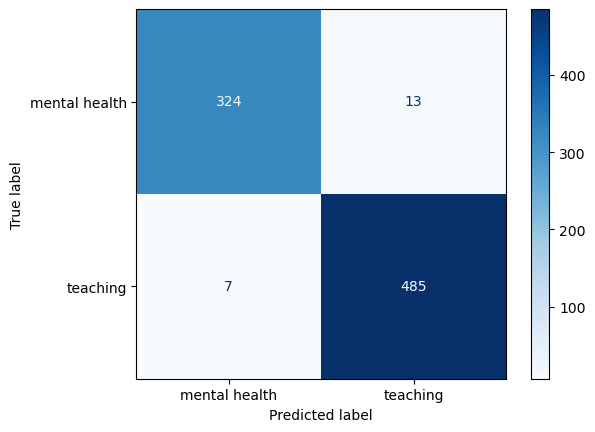

In [108]:
class_labels = ['mental health', 'teaching']
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap='Blues', display_labels= class_labels);

In [84]:
results = pd.DataFrame({
    'actual': y_test,
    'predicted': preds
})

In [85]:
wrongs = results[results.actual != results.predicted]
wrongs

,actual,predicted
1360,0,1
2276,1,0
59,0,1
887,0,1
1571,1,0
129,0,1
1086,0,1
175,0,1
827,0,1
2749,1,0


_Checking to see if these errors would be made my humans as well..._

1360: I am not a babysitter!	Does it bother anyone else on how the big focus for returning to school is based on getting the economy started back up? I hear it daily on our local news and GMA! Our superintendent even mentioned it in the email he sent out to families to today. It just makes me feel like I am going be forced back into an extremely unsafe environment during a Pandemic because they need me to be a free babysitter! I teach first grade. No matter how many hand sanitizer stations, attempt at possibly making them wear masks, and the even more amusing suggestion of trying to make them "social distance" is just not possible! A quote that has stuck with me as of late is "The Pandemic is not over because we are opening up. We are opening up because there is now a hospital bed available for you." I love my job and want to return, but not at the risk of spreading this awful virus and the effects of it just because of social and economic pressure. 😔

2276: I had Stress and very bad sleep for months, give a tip on how I can still waking up every day	Please :D

> **Actual: Mental Health, Predicted: Teaching.** Understandable

887	Giving up	I quit my position and I don't know what's next. 

The pressure of this job is tolerable, if I was working towards something. As it is now, I feel like I am joining a game of Monopoly 20 turns after everyone else. Just roll the dice and pay rent, that's my only option. I just want to stop. I want to say it's a mental health crisis, but the reality is, my poor mental health comes from social and financial poverty. I love Teaching. I love the job, really. But it's hard to keep rolling the dice, knowing I can't buy shit. I just work and work and pay for other people's shit. The only rent free spot on the board is jail. I've been thinking about how I could save for retirement and my conclusion is I will not be able to retire. No matter how much personal wealth I accumulate, without a house I will be relying on the generosity of others when I am too old to work. There is not future in this and I hat being told to roll the dice by people who own everything on the board. Just roll the dice, that's how you win! They say unsarcasticly. I want to give up. So I gave up. Now I am depressed.

> **Actual: Teaching, Predicted: Mental Health.** The key words such as "mental health crisis", "poor mental health", "depressed".

1867: I have a problem and I don't know what to do

"I'm 18 years old, I've failed 2 consecutive years in school and I don't know where to go with my life
the reason I've failed as a son, as a friend and as a student is my insecurity and hate for myself, because of that I also lied to my friends about I I was for about 3 years before they decided to give up on me, since then I did make new friends and I swore to never lie again but that feeling of hate became stronger and stronger every day till it became a constant scream inside my head, one day i was drunk (I'm Italian, here the legal age to drink is 18) and talked about it with my firends , they were supportive and understanding witch made me feel really guilty about it, i don't kniw why but telling people how i feel just makes me feel like a oiece of garbage, like i don't deserve any love or help, I've tried many times to help others and it makes me feel good but also bad because I'm happy that I can helo but I feel like it's an excuse for me to feel better about myself like "oh, i helped them, that must mean I'm a good person" at the start of the month I started going to a few festivities in a few towns in my region (notti bianche, cortes apertas) so for three days I only got drunk and smoked weed, after that I thought I was starting to feel better, the screaming suddenly stopped for the whole month and still haven't returned but I knew that something was wrong
last week I started having episodes where if I laughed or smiled my muscles started twitching and I startes going insane, i often punch the wall to relieve that feeling but it's starting to get worse, it's a strange feeling, my muscles start hardening and twitching and I can't control them anymore, before it was just by smiling or laughing but now it happens randomly, I figured that probably that feeling I had that there was something wrong was because I was maybe bottling everything up unconsciously or something and if it is like that I have to let those feelings out but I don't know how to do that and it's a problem because these episodes are getting more violent every time, I'm trying to control these episodes because at this point every time I have one I feel the need to hurt myself to relieve that feeling I don't know if it's hard to believe or not but can you please tell me if it's normal, I don't know what to do anymore"

> **Actual: Mental Health, Predicted: Teaching.** The keywords such as "school"

**I believe the wrong predictions to be due to the fact that there is overlap in terminology between the two reddit threads**

### Model 4: Using Tfid & LogRegression

In [86]:
X = combo['title_and_text']
y = combo['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1002)

In [87]:
pipe = Pipeline([
    ('tf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])


pipe_params = {
    'tf__max_features': [2_000, 3_000, 4_000, 5_000],
    'tf__stop_words': [None, 'english'],
    'tf__ngram_range': [(1, 1), (1, 2)],
    'lr__C': [0.5, 1, 2, 3]
}

In [88]:
gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 5)

In [89]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': [0.5, 1, 2, 3],
                         'tf__max_features': [2000, 3000, 4000, 5000],
                         'tf__ngram_range': [(1, 1), (1, 2)],
                         'tf__stop_words': [None, 'english']})

In [90]:
print(gs.best_params_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

{'lr__C': 3, 'tf__max_features': 5000, 'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}
0.9959742351046699
0.9734620024125452
